### Курсовая работа к курсу Megafon



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from src.utils import *

In [2]:
val_portion = 0.1
data_path = './data'
model_path = './model'
uncache_df_with_features = True
do_training = True

In [3]:
%%time
if not uncache_df_with_features:
    g_df_train = pd.read_csv(data_path + '/data_train.csv')
    g_df_test = pd.read_csv(data_path + '/data_test.csv')

    display(g_df_train)
    display(g_df_test)

Wall time: 0 ns


In [4]:
%%time
if not uncache_df_with_features:
    g_ddf_features, g_df_features_index = load_features(data_path + '/features.csv')

Wall time: 0 ns


In [5]:
%%time
if not uncache_df_with_features:
    g_df_train = add_features(g_df_train, g_ddf_features, g_df_features_index)
    g_df_train.shape

Wall time: 0 ns


In [6]:
%%time
if not uncache_df_with_features:
    g_df_test = add_features(g_df_test, g_ddf_features, g_df_features_index)
    g_df_test.shape

Wall time: 0 ns


In [7]:
if not uncache_df_with_features and cache_df_with_features:
    g_df_train.to_pickle(data_path + '/train_with_features.pkl')
    g_df_test.to_pickle(data_path + '/test_with_features.pkl')

In [8]:
if uncache_df_with_features:
    g_df_train = pd.read_pickle(data_path + '/train_with_features.pkl')
#    g_df_test = pd.read_pickle(data_path + '/test_with_features.pkl')
    display(g_df_train)


,Unnamed: 0_x,id,vas_id,buy_time_x,target,features_buy_time,Unnamed: 0_y,buy_time_y,0,1,...,243,244,245,246,247,248,249,250,251,252
0,705635,4106046,1.0,1531083600,0.0,1538341200,8754,1538341200,371.420029,74.880888,...,-875.373846,-522.770792,-23.996269,-37.630448,-164.747724,-5.832889,15.305572,-8.175933,-0.45614,0.0
1,480615,3674776,4.0,1531083600,0.0,1532898000,420,1532898000,-96.799971,384.200888,...,-669.373846,-392.770792,-23.996269,-33.630448,-144.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0
2,607549,174463,4.0,1531083600,0.0,1533502800,10406,1533502800,4.900029,-285.279112,...,-945.373846,-581.770792,-21.996269,-34.630448,-265.747724,-23.832889,1.305572,-12.175933,-0.45614,1.0
3,710294,1932030,4.0,1531083600,0.0,1539550800,5056,1539550800,-86.209971,95.220888,...,6635.626154,6912.229208,-25.996269,-37.630448,-98.747724,-7.832889,-0.694428,-7.175933,-0.45614,0.0
4,712140,4000165,1.0,1531083600,0.0,1547413200,742,1547413200,-96.799971,259.410888,...,-11.373846,-608.770792,-24.996269,-27.630448,-94.747724,-23.832889,-0.694428,-12.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,540697,2036774,6.0,1546203600,0.0,1541970000,4506183,1541970000,85.410029,-55.629112,...,-893.373846,-600.770792,20.003731,-37.630448,-158.747724,-20.832889,1.305572,-12.175933,-0.45614,0.0
2333,550478,690317,7.0,1546203600,0.0,1534712400,4502580,1534712400,-81.969971,331.210888,...,-977.373846,-613.770792,-25.996269,-37.630448,-256.747724,-23.832889,-0.694428,-10.175933,-0.45614,0.0
2334,546621,2820170,2.0,1546203600,0.0,1546203600,4509323,1546203600,-96.799971,-408.179112,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2335,536294,2407519,2.0,1546203600,0.0,1532898000,4507723,1532898000,161.680029,485.890888,...,16156.626154,-133.770792,-23.996269,-36.630448,1262.252276,79.167111,-0.694428,92.824067,-0.45614,0.0


Итерация с классификатором CatBoostClassifier, 1 категориальных признаков
Разделяем тренировочный набор ...
Тренировочный набор: 748487 x 260
Валидационный набор: 83166 x 260
X_train_train: 748487 x 260
y_train_train: 748487
X_train_val: 83166 x 260
y_train_val: 83166
Создаем pipeline ...
Тренируем ...
Learning rate set to 0.173864
0:	learn: 0.4449047	total: 321ms	remaining: 5m 20s
1:	learn: 0.3143133	total: 505ms	remaining: 4m 11s
2:	learn: 0.2570162	total: 665ms	remaining: 3m 41s
3:	learn: 0.2234485	total: 861ms	remaining: 3m 34s
4:	learn: 0.1950712	total: 1.04s	remaining: 3m 26s
5:	learn: 0.1841212	total: 1.18s	remaining: 3m 14s
6:	learn: 0.1728706	total: 1.36s	remaining: 3m 13s
7:	learn: 0.1686514	total: 1.5s	remaining: 3m 6s
8:	learn: 0.1636769	total: 1.67s	remaining: 3m 3s
9:	learn: 0.1607902	total: 1.85s	remaining: 3m 3s
10:	learn: 0.1597298	total: 1.98s	remaining: 2m 58s
11:	learn: 0.1582635	total: 2.16s	remaining: 2m 57s
12:	learn: 0.1572087	total: 2.34s	remaining: 2m 57s
13:	

152:	learn: 0.1533742	total: 24.9s	remaining: 2m 17s
153:	learn: 0.1533585	total: 25s	remaining: 2m 17s
154:	learn: 0.1533457	total: 25.3s	remaining: 2m 17s
155:	learn: 0.1533270	total: 25.4s	remaining: 2m 17s
156:	learn: 0.1533142	total: 25.5s	remaining: 2m 17s
157:	learn: 0.1532965	total: 25.7s	remaining: 2m 16s
158:	learn: 0.1532800	total: 25.9s	remaining: 2m 16s
159:	learn: 0.1532638	total: 26s	remaining: 2m 16s
160:	learn: 0.1532594	total: 26.2s	remaining: 2m 16s
161:	learn: 0.1532470	total: 26.3s	remaining: 2m 16s
162:	learn: 0.1532316	total: 26.5s	remaining: 2m 16s
163:	learn: 0.1532153	total: 26.7s	remaining: 2m 16s
164:	learn: 0.1532045	total: 26.9s	remaining: 2m 15s
165:	learn: 0.1531879	total: 27s	remaining: 2m 15s
166:	learn: 0.1531797	total: 27.2s	remaining: 2m 15s
167:	learn: 0.1531702	total: 27.3s	remaining: 2m 15s
168:	learn: 0.1531639	total: 27.4s	remaining: 2m 14s
169:	learn: 0.1531629	total: 27.6s	remaining: 2m 14s
170:	learn: 0.1531525	total: 27.7s	remaining: 2m 14s

309:	learn: 0.1514904	total: 49.4s	remaining: 1m 49s
310:	learn: 0.1514708	total: 49.5s	remaining: 1m 49s
311:	learn: 0.1514612	total: 49.7s	remaining: 1m 49s
312:	learn: 0.1514445	total: 49.9s	remaining: 1m 49s
313:	learn: 0.1514422	total: 50s	remaining: 1m 49s
314:	learn: 0.1514374	total: 50.1s	remaining: 1m 49s
315:	learn: 0.1514276	total: 50.3s	remaining: 1m 48s
316:	learn: 0.1514236	total: 50.4s	remaining: 1m 48s
317:	learn: 0.1514123	total: 50.5s	remaining: 1m 48s
318:	learn: 0.1514066	total: 50.7s	remaining: 1m 48s
319:	learn: 0.1513995	total: 50.9s	remaining: 1m 48s
320:	learn: 0.1513810	total: 51.1s	remaining: 1m 48s
321:	learn: 0.1513744	total: 51.3s	remaining: 1m 47s
322:	learn: 0.1513693	total: 51.4s	remaining: 1m 47s
323:	learn: 0.1513615	total: 51.5s	remaining: 1m 47s
324:	learn: 0.1513470	total: 51.7s	remaining: 1m 47s
325:	learn: 0.1513375	total: 51.9s	remaining: 1m 47s
326:	learn: 0.1513262	total: 52.1s	remaining: 1m 47s
327:	learn: 0.1513121	total: 52.2s	remaining: 1m

464:	learn: 0.1498393	total: 1m 14s	remaining: 1m 25s
465:	learn: 0.1498365	total: 1m 14s	remaining: 1m 25s
466:	learn: 0.1498231	total: 1m 14s	remaining: 1m 25s
467:	learn: 0.1498145	total: 1m 15s	remaining: 1m 25s
468:	learn: 0.1498051	total: 1m 15s	remaining: 1m 25s
469:	learn: 0.1497917	total: 1m 15s	remaining: 1m 25s
470:	learn: 0.1497828	total: 1m 15s	remaining: 1m 24s
471:	learn: 0.1497697	total: 1m 15s	remaining: 1m 24s
472:	learn: 0.1497520	total: 1m 15s	remaining: 1m 24s
473:	learn: 0.1497483	total: 1m 16s	remaining: 1m 24s
474:	learn: 0.1497413	total: 1m 16s	remaining: 1m 24s
475:	learn: 0.1497241	total: 1m 16s	remaining: 1m 24s
476:	learn: 0.1497171	total: 1m 16s	remaining: 1m 23s
477:	learn: 0.1497050	total: 1m 16s	remaining: 1m 23s
478:	learn: 0.1496899	total: 1m 16s	remaining: 1m 23s
479:	learn: 0.1496756	total: 1m 17s	remaining: 1m 23s
480:	learn: 0.1496689	total: 1m 17s	remaining: 1m 23s
481:	learn: 0.1496522	total: 1m 17s	remaining: 1m 23s
482:	learn: 0.1496344	total:

618:	learn: 0.1482614	total: 1m 39s	remaining: 1m 1s
619:	learn: 0.1482559	total: 1m 39s	remaining: 1m 1s
620:	learn: 0.1482549	total: 1m 39s	remaining: 1m
621:	learn: 0.1482427	total: 1m 39s	remaining: 1m
622:	learn: 0.1482258	total: 1m 40s	remaining: 1m
623:	learn: 0.1482122	total: 1m 40s	remaining: 1m
624:	learn: 0.1481983	total: 1m 40s	remaining: 1m
625:	learn: 0.1481976	total: 1m 40s	remaining: 1m
626:	learn: 0.1481823	total: 1m 40s	remaining: 59.9s
627:	learn: 0.1481713	total: 1m 40s	remaining: 59.7s
628:	learn: 0.1481595	total: 1m 40s	remaining: 59.6s
629:	learn: 0.1481556	total: 1m 41s	remaining: 59.4s
630:	learn: 0.1481409	total: 1m 41s	remaining: 59.2s
631:	learn: 0.1481274	total: 1m 41s	remaining: 59.1s
632:	learn: 0.1481099	total: 1m 41s	remaining: 59s
633:	learn: 0.1480966	total: 1m 41s	remaining: 58.8s
634:	learn: 0.1480801	total: 1m 42s	remaining: 58.6s
635:	learn: 0.1480630	total: 1m 42s	remaining: 58.5s
636:	learn: 0.1480579	total: 1m 42s	remaining: 58.3s
637:	learn: 0

775:	learn: 0.1467495	total: 2m 4s	remaining: 35.9s
776:	learn: 0.1467363	total: 2m 4s	remaining: 35.8s
777:	learn: 0.1467199	total: 2m 4s	remaining: 35.6s
778:	learn: 0.1467037	total: 2m 5s	remaining: 35.5s
779:	learn: 0.1466915	total: 2m 5s	remaining: 35.3s
780:	learn: 0.1466890	total: 2m 5s	remaining: 35.2s
781:	learn: 0.1466878	total: 2m 5s	remaining: 35s
782:	learn: 0.1466785	total: 2m 5s	remaining: 34.8s
783:	learn: 0.1466759	total: 2m 5s	remaining: 34.7s
784:	learn: 0.1466626	total: 2m 5s	remaining: 34.5s
785:	learn: 0.1466570	total: 2m 6s	remaining: 34.3s
786:	learn: 0.1466421	total: 2m 6s	remaining: 34.2s
787:	learn: 0.1466312	total: 2m 6s	remaining: 34s
788:	learn: 0.1466272	total: 2m 6s	remaining: 33.9s
789:	learn: 0.1466222	total: 2m 6s	remaining: 33.7s
790:	learn: 0.1466022	total: 2m 7s	remaining: 33.6s
791:	learn: 0.1465882	total: 2m 7s	remaining: 33.4s
792:	learn: 0.1465697	total: 2m 7s	remaining: 33.3s
793:	learn: 0.1465598	total: 2m 7s	remaining: 33.1s
794:	learn: 0.14

931:	learn: 0.1452195	total: 2m 30s	remaining: 10.9s
932:	learn: 0.1452091	total: 2m 30s	remaining: 10.8s
933:	learn: 0.1452017	total: 2m 30s	remaining: 10.6s
934:	learn: 0.1451959	total: 2m 30s	remaining: 10.5s
935:	learn: 0.1451882	total: 2m 30s	remaining: 10.3s
936:	learn: 0.1451850	total: 2m 30s	remaining: 10.1s
937:	learn: 0.1451833	total: 2m 31s	remaining: 9.98s
938:	learn: 0.1451659	total: 2m 31s	remaining: 9.82s
939:	learn: 0.1451478	total: 2m 31s	remaining: 9.66s
940:	learn: 0.1451306	total: 2m 31s	remaining: 9.51s
941:	learn: 0.1451175	total: 2m 31s	remaining: 9.35s
942:	learn: 0.1451156	total: 2m 31s	remaining: 9.18s
943:	learn: 0.1451090	total: 2m 32s	remaining: 9.02s
944:	learn: 0.1450936	total: 2m 32s	remaining: 8.86s
945:	learn: 0.1450796	total: 2m 32s	remaining: 8.7s
946:	learn: 0.1450677	total: 2m 32s	remaining: 8.54s
947:	learn: 0.1450620	total: 2m 32s	remaining: 8.38s
948:	learn: 0.1450501	total: 2m 32s	remaining: 8.22s
949:	learn: 0.1450466	total: 2m 33s	remaining: 

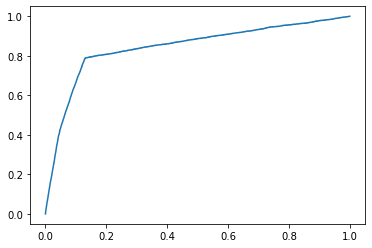

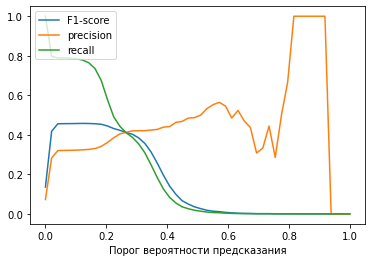

Wall time: 3min 12s


In [9]:
%%time
if do_training:
    r = iteration(CatBoostClassifier(class_weights=[0.93, 0.7]), g_df_train, model_path + "./CatBoostClassifier_train_val.pkl", val_portion=val_portion)


In [10]:
%%time
if do_training:
    r = iteration(CatBoostClassifier(class_weights=[0.93, 0.7]), g_df_train, model_path + "./CatBoostClassifier_final.pkl", val_portion=0)


Итерация с классификатором CatBoostClassifier, 1 категориальных признаков
Разделяем тренировочный набор ...
Тренировочный набор: 831653 x 260
Валидационный набор: 0 x 260
X_train_train: 831653 x 260
y_train_train: 831653
X_train_val: 0 x 260
y_train_val: 0
Создаем pipeline ...
Тренируем ...
Learning rate set to 0.181865
0:	learn: 0.4361036	total: 174ms	remaining: 2m 53s
1:	learn: 0.3250512	total: 367ms	remaining: 3m 2s
2:	learn: 0.2481406	total: 538ms	remaining: 2m 58s
3:	learn: 0.2168944	total: 691ms	remaining: 2m 52s
4:	learn: 0.1985522	total: 900ms	remaining: 2m 59s
5:	learn: 0.1805308	total: 1.1s	remaining: 3m 2s
6:	learn: 0.1704427	total: 1.31s	remaining: 3m 6s
7:	learn: 0.1667296	total: 1.53s	remaining: 3m 9s
8:	learn: 0.1625619	total: 1.71s	remaining: 3m 8s
9:	learn: 0.1598148	total: 1.91s	remaining: 3m 9s
10:	learn: 0.1581496	total: 2.07s	remaining: 3m 6s
11:	learn: 0.1576149	total: 2.28s	remaining: 3m 7s
12:	learn: 0.1567726	total: 2.46s	remaining: 3m 6s
13:	learn: 0.1562179	t

154:	learn: 0.1535753	total: 28.9s	remaining: 2m 37s
155:	learn: 0.1535655	total: 29s	remaining: 2m 36s
156:	learn: 0.1535544	total: 29.2s	remaining: 2m 36s
157:	learn: 0.1535417	total: 29.3s	remaining: 2m 36s
158:	learn: 0.1535292	total: 29.5s	remaining: 2m 35s
159:	learn: 0.1535287	total: 29.6s	remaining: 2m 35s
160:	learn: 0.1535092	total: 29.8s	remaining: 2m 35s
161:	learn: 0.1534960	total: 30s	remaining: 2m 34s
162:	learn: 0.1534891	total: 30.1s	remaining: 2m 34s
163:	learn: 0.1534781	total: 30.3s	remaining: 2m 34s
164:	learn: 0.1534575	total: 30.4s	remaining: 2m 34s
165:	learn: 0.1534445	total: 30.6s	remaining: 2m 33s
166:	learn: 0.1534379	total: 30.8s	remaining: 2m 33s
167:	learn: 0.1534221	total: 30.9s	remaining: 2m 33s
168:	learn: 0.1534190	total: 31.1s	remaining: 2m 32s
169:	learn: 0.1534060	total: 31.2s	remaining: 2m 32s
170:	learn: 0.1533898	total: 31.5s	remaining: 2m 32s
171:	learn: 0.1533786	total: 31.6s	remaining: 2m 32s
172:	learn: 0.1533709	total: 31.8s	remaining: 2m 3

310:	learn: 0.1519216	total: 57s	remaining: 2m 6s
311:	learn: 0.1519106	total: 57.2s	remaining: 2m 6s
312:	learn: 0.1519042	total: 57.4s	remaining: 2m 6s
313:	learn: 0.1518914	total: 57.6s	remaining: 2m 5s
314:	learn: 0.1518846	total: 57.7s	remaining: 2m 5s
315:	learn: 0.1518739	total: 57.9s	remaining: 2m 5s
316:	learn: 0.1518673	total: 58.1s	remaining: 2m 5s
317:	learn: 0.1518579	total: 58.2s	remaining: 2m 4s
318:	learn: 0.1518456	total: 58.4s	remaining: 2m 4s
319:	learn: 0.1518350	total: 58.6s	remaining: 2m 4s
320:	learn: 0.1518271	total: 58.8s	remaining: 2m 4s
321:	learn: 0.1518180	total: 59s	remaining: 2m 4s
322:	learn: 0.1518107	total: 59.2s	remaining: 2m 4s
323:	learn: 0.1518028	total: 59.4s	remaining: 2m 3s
324:	learn: 0.1518006	total: 59.5s	remaining: 2m 3s
325:	learn: 0.1517950	total: 59.7s	remaining: 2m 3s
326:	learn: 0.1517918	total: 59.8s	remaining: 2m 3s
327:	learn: 0.1517793	total: 1m	remaining: 2m 3s
328:	learn: 0.1517634	total: 1m	remaining: 2m 2s
329:	learn: 0.1517614	

465:	learn: 0.1504143	total: 1m 24s	remaining: 1m 36s
466:	learn: 0.1503959	total: 1m 24s	remaining: 1m 36s
467:	learn: 0.1503842	total: 1m 24s	remaining: 1m 35s
468:	learn: 0.1503645	total: 1m 24s	remaining: 1m 35s
469:	learn: 0.1503535	total: 1m 24s	remaining: 1m 35s
470:	learn: 0.1503434	total: 1m 24s	remaining: 1m 35s
471:	learn: 0.1503260	total: 1m 25s	remaining: 1m 35s
472:	learn: 0.1503243	total: 1m 25s	remaining: 1m 35s
473:	learn: 0.1503103	total: 1m 25s	remaining: 1m 34s
474:	learn: 0.1502993	total: 1m 25s	remaining: 1m 34s
475:	learn: 0.1502945	total: 1m 25s	remaining: 1m 34s
476:	learn: 0.1502858	total: 1m 25s	remaining: 1m 34s
477:	learn: 0.1502818	total: 1m 26s	remaining: 1m 34s
478:	learn: 0.1502674	total: 1m 26s	remaining: 1m 33s
479:	learn: 0.1502500	total: 1m 26s	remaining: 1m 33s
480:	learn: 0.1502407	total: 1m 26s	remaining: 1m 33s
481:	learn: 0.1502309	total: 1m 26s	remaining: 1m 33s
482:	learn: 0.1502267	total: 1m 27s	remaining: 1m 33s
483:	learn: 0.1502102	total:

617:	learn: 0.1489326	total: 1m 51s	remaining: 1m 8s
618:	learn: 0.1489294	total: 1m 51s	remaining: 1m 8s
619:	learn: 0.1489208	total: 1m 51s	remaining: 1m 8s
620:	learn: 0.1489163	total: 1m 51s	remaining: 1m 8s
621:	learn: 0.1489029	total: 1m 52s	remaining: 1m 8s
622:	learn: 0.1488914	total: 1m 52s	remaining: 1m 7s
623:	learn: 0.1488789	total: 1m 52s	remaining: 1m 7s
624:	learn: 0.1488771	total: 1m 52s	remaining: 1m 7s
625:	learn: 0.1488672	total: 1m 52s	remaining: 1m 7s
626:	learn: 0.1488603	total: 1m 52s	remaining: 1m 7s
627:	learn: 0.1488474	total: 1m 53s	remaining: 1m 7s
628:	learn: 0.1488393	total: 1m 53s	remaining: 1m 6s
629:	learn: 0.1488229	total: 1m 53s	remaining: 1m 6s
630:	learn: 0.1488092	total: 1m 53s	remaining: 1m 6s
631:	learn: 0.1488059	total: 1m 53s	remaining: 1m 6s
632:	learn: 0.1487896	total: 1m 54s	remaining: 1m 6s
633:	learn: 0.1487865	total: 1m 54s	remaining: 1m 5s
634:	learn: 0.1487805	total: 1m 54s	remaining: 1m 5s
635:	learn: 0.1487701	total: 1m 54s	remaining:

774:	learn: 0.1474766	total: 2m 18s	remaining: 40.2s
775:	learn: 0.1474720	total: 2m 18s	remaining: 40.1s
776:	learn: 0.1474618	total: 2m 18s	remaining: 39.9s
777:	learn: 0.1474545	total: 2m 19s	remaining: 39.7s
778:	learn: 0.1474524	total: 2m 19s	remaining: 39.5s
779:	learn: 0.1474396	total: 2m 19s	remaining: 39.3s
780:	learn: 0.1474373	total: 2m 19s	remaining: 39.1s
781:	learn: 0.1474243	total: 2m 19s	remaining: 39s
782:	learn: 0.1474112	total: 2m 19s	remaining: 38.8s
783:	learn: 0.1474013	total: 2m 20s	remaining: 38.6s
784:	learn: 0.1473926	total: 2m 20s	remaining: 38.4s
785:	learn: 0.1473887	total: 2m 20s	remaining: 38.3s
786:	learn: 0.1473751	total: 2m 20s	remaining: 38.1s
787:	learn: 0.1473572	total: 2m 20s	remaining: 37.9s
788:	learn: 0.1473475	total: 2m 21s	remaining: 37.7s
789:	learn: 0.1473374	total: 2m 21s	remaining: 37.6s
790:	learn: 0.1473301	total: 2m 21s	remaining: 37.4s
791:	learn: 0.1473161	total: 2m 21s	remaining: 37.2s
792:	learn: 0.1473121	total: 2m 21s	remaining: 3

931:	learn: 0.1459671	total: 2m 47s	remaining: 12.2s
932:	learn: 0.1459524	total: 2m 47s	remaining: 12s
933:	learn: 0.1459430	total: 2m 47s	remaining: 11.8s
934:	learn: 0.1459320	total: 2m 47s	remaining: 11.7s
935:	learn: 0.1459179	total: 2m 47s	remaining: 11.5s
936:	learn: 0.1459144	total: 2m 48s	remaining: 11.3s
937:	learn: 0.1459090	total: 2m 48s	remaining: 11.1s
938:	learn: 0.1459073	total: 2m 48s	remaining: 10.9s
939:	learn: 0.1459007	total: 2m 48s	remaining: 10.8s
940:	learn: 0.1458948	total: 2m 48s	remaining: 10.6s
941:	learn: 0.1458839	total: 2m 49s	remaining: 10.4s
942:	learn: 0.1458711	total: 2m 49s	remaining: 10.2s
943:	learn: 0.1458606	total: 2m 49s	remaining: 10.1s
944:	learn: 0.1458534	total: 2m 49s	remaining: 9.87s
945:	learn: 0.1458519	total: 2m 49s	remaining: 9.69s
946:	learn: 0.1458432	total: 2m 49s	remaining: 9.51s
947:	learn: 0.1458338	total: 2m 50s	remaining: 9.33s
948:	learn: 0.1458231	total: 2m 50s	remaining: 9.15s
949:	learn: 0.1458177	total: 2m 50s	remaining: 8

In [13]:

from src.luigi_pipeline import *

luigi.build([LTaskPredict(pipeline_path=model_path + '/CatBoostClassifier_final.pkl')])
 

DEBUG: Checking if LTaskPredict(data_dir=./data, features_path=, input_path=, output_path=, pipeline_path=./model/CatBoostClassifier_final.pkl, threshold=0.2) is complete
DEBUG: Checking if LTaskAddFeatures(data_dir=./data, features_path=, input_path=./data/data_test.csv) is complete
INFO: Informed scheduler that task   LTaskPredict___data___81441beacf   has status   PENDING
DEBUG: Checking if LTaskIndexFeatures(data_dir=./data, features_path=) is complete
INFO: Informed scheduler that task   LTaskAddFeatures___data____data_data_test_b26d8b1754   has status   PENDING
INFO: Informed scheduler that task   LTaskIndexFeatures___data__76fbc9d49b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 3
INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) running   LTaskIndexFeatures(data_dir=./data, features_path=)


загружаем df_features_short ...
[########################################] | 100% Completed |  4min 49.6s
сортируем df_features_short ...


INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) done      LTaskIndexFeatures(data_dir=./data, features_path=)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LTaskIndexFeatures___data__76fbc9d49b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 2
INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) running   LTaskAddFeatures(data_dir=./data, features_path=, input_path=./data/data_test.csv)


Добавляем признаки в df 71231 x 4 ...
сортируем df 71231 x 4 ...
merge_asof ...
df_ft_keys: 71231 x 5
merge ...
compute ...
[########################################] | 100% Completed |  4min 43.2s


INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) done      LTaskAddFeatures(data_dir=./data, features_path=, input_path=./data/data_test.csv)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LTaskAddFeatures___data____data_data_test_b26d8b1754   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) running   LTaskPredict(data_dir=./data, features_path=, input_path=, output_path=, pipeline_path=./model/CatBoostClassifier_final.pkl, threshold=0.2)


Загружаем данные из ./data/input_with_features.csv
Загружаем модель из ./model/CatBoostClassifier_final.pkl
Загрузка из ./model/CatBoostClassifier_final.pkl ...
Загрузка из ./model/CatBoostClassifier_final.pkl - ok
Получаем предсказания ...
Сохраняем результат в ./data/predictions.csv


INFO: [pid 15164] Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) done      LTaskPredict(data_dir=./data, features_path=, input_path=, output_path=, pipeline_path=./model/CatBoostClassifier_final.pkl, threshold=0.2)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LTaskPredict___data___81441beacf   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=501550971, workers=1, host=DESKTOP-Q4O4OTJ, username=n_ned, pid=15164) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 3 tasks of which:
* 3 ran successfully:
    - 1 LTaskAddFeatures(data_dir=./data, features_path=, input_path=./data/data_test.csv)
    - 1 LTaskIndexFeatures(data_dir=./data, features_path=)
    - 1 LTaskPredict(...)

This progress looks :) because there were no failed tasks or missing dependencies

=

True